# Squirmer crystals

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import copy
import auxiliary7 as aux

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

%reload_ext autoreload
%autoreload 2

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
src_n = 40
dataDir = f'../data.lbm/{src_n}/'
# dataDir = f'../src/{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dataDir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

100

# Fluid

In [4]:
# id += 1
id = -1
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()

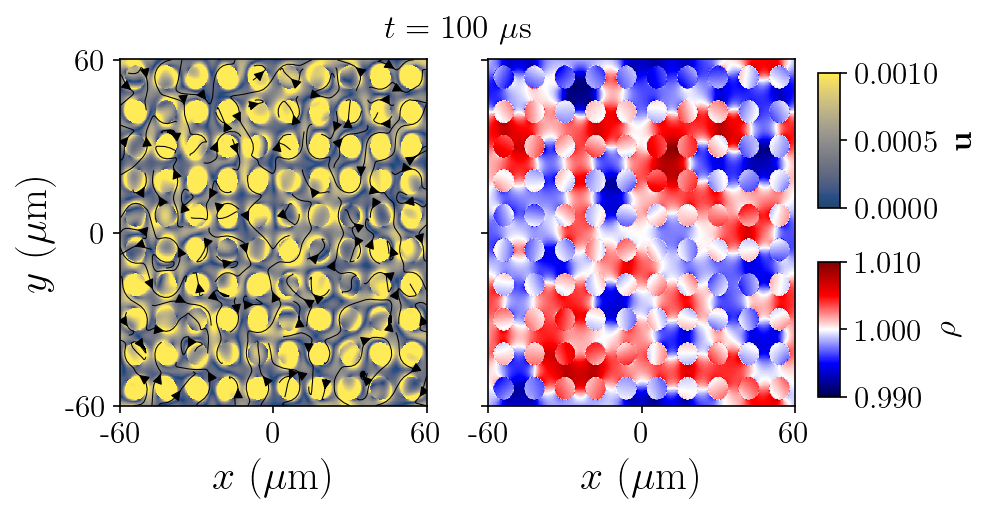

In [5]:
title = f"$t = {fluidDf.time.values[0]:.0f}$"+" $\\mu \\mathrm{s}$"
fig, axes = aux.fluidOverview(fluidDf, title, maxFluidSpeed=1e-3, maxMassDensity=1e-2)
# plt.savefig("figure1.png", format="png", transparent=True, dpi=1000, bbox_inches="tight")
plt.show()

# Particle

In [ ]:
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")
fig, axes = aux.particleTrjOverview(particleDf)
plt.show()

## particle velocity is compared to analytical results

In [ ]:
flux_x = fluidDf.query('coordinate_x == -20').fluidVelocity_x.mean()
flux_y = fluidDf.query('coordinate_x == -20').fluidVelocity_y.mean()
flux_z = fluidDf.query('coordinate_x == -20').fluidVelocity_y.mean()

vAvgX = particleDf.velocity_x.mean()
vAvgY = particleDf.velocity_y.mean()
vAvgZ = particleDf.velocity_z.mean()

particleVelocityLabFrame = [vAvgX - flux_x, vAvgY - flux_y, vAvgZ - flux_z]
particleVelocityLabFrame # μm/μs

In [ ]:
expectedSpeed = 1e-3
relativeError = np.abs(expectedSpeed - np.linalg.norm(particleVelocityLabFrame))/expectedSpeed
relativeError

# Animation

In [6]:
# necessary directories are created
outputDir = f"frames.{src_n}"
os.system(f'mkdir -p anims')
os.system(f'mkdir {outputDir}')

# the data is read and frames are saved
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")
for tickId in np.arange(len(ticks)):
    fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[tickId]}.csv").set_index(["id_x","id_y"]).sort_index()
    title = f'$t = {fluidDf.time.values[-1]:.0f}$'+' $\\mu \\mathrm{s}$'
    fig, axes = aux.fluidOverview(fluidDf, title, maxFluidSpeed=1e-3, maxMassDensity=1e-2)
    # plt.savefig("figure1.png", format="png", transparent=True, dpi=1000, bbox_inches="tight")

    plt.savefig(f"{outputDir}/{tickId}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close()
    print(f'\r{tickId}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

# ffmpeg is used to create the animation
mkAnimSh = f'ffmpeg -framerate 20 -i {outputDir}/%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -loglevel quiet anims/src_{src_n}.mp4'
os.system(mkAnimSh)

# the directory with the frames is erased
os.system(f'rm -r {outputDir}')

0